Training an image classifier
We will do the following steps in order:

- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

1) Load the dataset CIFAR10

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [29]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 32
# Load the train and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes=('plane', 'car', 'bird', 'cat',
         'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's show some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


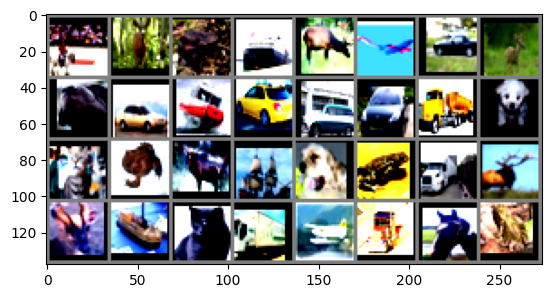

horse deer  frog  ship  deer  plane car   deer  dog   car   ship  car   car   car   truck dog   cat   frog  deer  ship  dog   frog  truck deer  deer  ship  cat   truck plane truck horse frog 


In [30]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2) Define a CNN

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # 32x32 -> 16x16
        x = self.pool(F.relu(self.conv2(x)))    # 16x16 -> 8x8
        x = self.pool(F.relu(self.conv3(x)))    # 8x8 -> 4x4
        x = x.view(-1, 128 * 4 * 4)               # Flatten per il fully connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()

3) Define a Loss Function and Optimizer

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4) Train the network: train our data with loop (epochs)

In [41]:
epochs = 30
model = net.cuda()

for epoch in range(epochs):  # loop over the dataset multiple times
    total_loss = 0.0
    total_samples = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
        total_samples += labels.size(0)
    avg_loss = total_loss / total_samples
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
print('Finished Training')

Epoch 1, Loss: 0.0190
Epoch 2, Loss: 0.0189
Epoch 3, Loss: 0.0189
Epoch 4, Loss: 0.0189
Epoch 5, Loss: 0.0190
Epoch 6, Loss: 0.0189
Epoch 7, Loss: 0.0189
Epoch 8, Loss: 0.0189
Epoch 9, Loss: 0.0190
Epoch 10, Loss: 0.0190
Epoch 11, Loss: 0.0190
Epoch 12, Loss: 0.0190
Epoch 13, Loss: 0.0190
Epoch 14, Loss: 0.0190
Epoch 15, Loss: 0.0189
Epoch 16, Loss: 0.0191
Epoch 17, Loss: 0.0190
Epoch 18, Loss: 0.0191
Epoch 19, Loss: 0.0189
Epoch 20, Loss: 0.0190
Epoch 21, Loss: 0.0189
Epoch 22, Loss: 0.0189
Epoch 23, Loss: 0.0190
Epoch 24, Loss: 0.0189
Epoch 25, Loss: 0.0190
Epoch 26, Loss: 0.0190
Epoch 27, Loss: 0.0189
Epoch 28, Loss: 0.0190
Epoch 29, Loss: 0.0189
Epoch 30, Loss: 0.0190
Finished Training


Let's save our trained model

In [42]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

5) Test the network on the test data
We will check by predicting the class label that the NN outputs, and checking it against the ground-truth. I fthe prediction is correct , we add the sample to teh list of correct predictions.

First step, let's display an image from the test set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


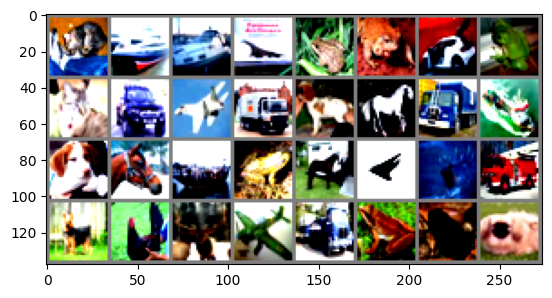

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  
Predicted:    cat   ship  ship  ship  frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck deer  bird  deer  plane truck frog  frog  dog  


In [43]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
images, labels = images.cuda(), labels.cuda()
outputs = model(images)
_, preds = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))
print('Predicted:   ', ' '.join(f'{classes[preds[j]]:5s}' for j in range(32)))

The results are pretty good, just the last one is not correct. So, now, let's watch the results for teh entire test set.

In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # move inputs and labels to the same device as the model (GPU)
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 78.51 %


Now, let's identify the classes taht performed well and the ones that didn't.

In [45]:
# prepare to count predictions for each class
# use integer class indices as dict keys to match how labels are indexed
correct_pred = {i: 0 for i in range(len(classes))}
total_pred = {i: 0 for i in range(len(classes))}

corrects = 0
totals = 0
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        totals += labels.size(0)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            label_idx = label.item()
            pred_idx = prediction.item()
            total_pred[label_idx] += 1
            if label_idx == pred_idx:
                correct_pred[label_idx] += 1
                corrects += 1


# print accuracy for each class
for class_idx, correct_count in correct_pred.items():
    total_for_class = total_pred.get(class_idx, 0)
    accuracy = 100 * float(correct_count) / total_for_class if total_for_class > 0 else 0.0
    print(f'Accuracy for class: {classes[class_idx]:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 80.6 %
Accuracy for class: car   is 93.1 %
Accuracy for class: bird  is 72.5 %
Accuracy for class: cat   is 60.1 %
Accuracy for class: deer  is 71.8 %
Accuracy for class: dog   is 69.1 %
Accuracy for class: frog  is 76.5 %
Accuracy for class: horse is 87.2 %
Accuracy for class: ship  is 91.3 %
Accuracy for class: truck is 82.9 %
